Sequence labeling for parts of speech and Named Entities

In [1]:
!pip install datasets seqeval #The seqeval library, which is used for evaluating sequence labeling tasks like named entity recognition (NER)
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=82f336def39e3f7a21a6989c0014c5af1802d00365ae4daa4317947c2f93b710
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency r

In [2]:
from datasets import load_dataset
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dropout, Bidirectional, Input
import matplotlib.pyplot as plt


In [3]:
dataset=load_dataset("conll2003")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
train_data = dataset["train"]
test_data = dataset["test"]

train_sentences = [[word for word in sentence["tokens"]] for sentence in train_data]
train_labels = [[label for label in sentence["ner_tags"]] for sentence in train_data]

test_sentences = [[word for word in sentence["tokens"]] for sentence in test_data]
test_labels = [[label for label in sentence["ner_tags"]] for sentence in test_data]


In [5]:
unique_labels = set(label for sublist in train_labels for label in sublist)
label2idx = {label: i for i, label in enumerate(unique_labels)}
idx2label = {i: label for label, i in label2idx.items()}


In [6]:
max_len = 75
word2idx = {word: i + 2 for i, word in enumerate(set(word for sentence in train_sentences for word in sentence))}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {i: word for word, i in word2idx.items()}


In [7]:
X_train = pad_sequences([[word2idx.get(w, 1) for w in s] for s in train_sentences],
                         padding="post", maxlen=max_len)
X_test = pad_sequences([[word2idx.get(w, 1) for w in s] for s in test_sentences],
                        padding="post", maxlen=max_len)

y_train = pad_sequences([[label2idx[t] for t in ts] for ts in train_labels],
                         padding="post", maxlen=max_len)
y_test = pad_sequences([[label2idx[t] for t in ts] for ts in test_labels],
                        padding="post", maxlen=max_len)

y_train = [to_categorical(i, num_classes=len(label2idx)) for i in y_train]
y_test = [to_categorical(i, num_classes=len(label2idx)) for i in y_test]


In [8]:
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Dense, Input
from tensorflow.keras.models import Model

def build_model():
    input_layer = Input(shape=(max_len,))
    model = Embedding(input_dim=len(word2idx), output_dim=128)(input_layer)
    model = LSTM(64, return_sequences=True)(model)
    model = TimeDistributed(Dense(len(label2idx), activation="softmax"))(model)
    model = Model(input_layer, model)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 75, 128)             │       3,024,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 75, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 75, 9)               │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,073,993 (11.73 MB)

 Trainable params: 3,073,993 (11.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9527 - loss: 0.2700 - val_accuracy: 0.9751 - val_loss: 0.0828
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9821 - loss: 0.0631 - val_accuracy: 0.9835 - val_loss: 0.0599
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9928 - loss: 0.0319 - val_accuracy: 0.9868 - val_loss: 0.0466
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9970 - loss: 0.0139 - val_accuracy: 0.9861 - val_loss: 0.0455
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9981 - loss: 0.0079 - val_accuracy: 0.9861 - val_loss: 0.0472
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9857 - val_loss: 0.0498
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 0.9860 - val_loss: 0.0530


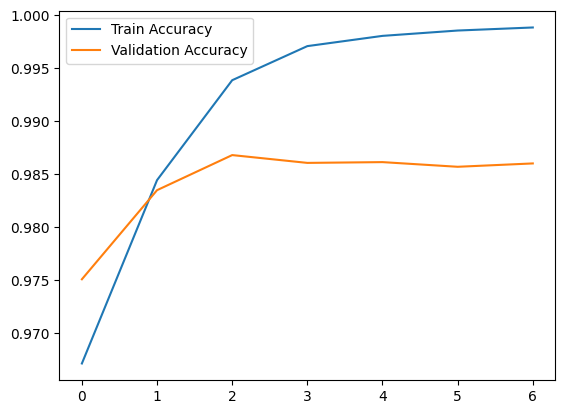

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

early_stop = EarlyStopping(monitor="val_loss", patience=3)

history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_test, np.array(y_test)),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=[early_stop]
)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


Streamlit

In [10]:
!pip install streamlit tensorflow datasets npx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00
